# Human Activity Recognition — k-Nearest Neighbors Notebook

This notebook focuses on k-NN experiments and assumes separate TRAIN_CSV and TEST_CSV. It loads both, aligns features, fits preprocessors on training only (scaler, selectors, PCA), and evaluates k-NN on the provided test set.

Authors: girdauskaite + partner


## 0) Install (run if needed)
Uncomment if missing packages.

In [4]:
# !pip install scikit-learn matplotlib seaborn joblib
print('skip install if already done')

skip install if already done


## 1) Imports & config

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

TRAIN_CSV = '../data/activity_train.csv'   # path to train CSV
TEST_CSV  = '../data/activity_test.csv'    # path to test CSV

os.makedirs('models', exist_ok=True)
print('imports done')

imports done


## 2) Load train & test CSVs and align features

In [6]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
print('train shape:', df_train.shape)
print('test  shape:', df_test.shape)
if 'activity' not in df_train.columns:
    raise ValueError('TRAIN_CSV must contain `activity` column')
has_test_labels = 'activity' in df_test.columns
print('test has activity labels?', has_test_labels)

X_train = df_train.drop(columns=['activity'])
y_train = df_train['activity'].copy()
if has_test_labels:
    X_test = df_test.drop(columns=['activity'])
    y_test = df_test['activity'].copy()
else:
    X_test = df_test.copy()
    y_test = None

# Align feature columns
train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
missing_in_test = [c for c in train_cols if c not in test_cols]
extra_in_test = [c for c in test_cols if c not in train_cols]
if missing_in_test:
    print('Adding missing columns to test:', missing_in_test[:10], '...')
    for c in missing_in_test:
        X_test[c] = 0.0
if extra_in_test:
    print('Dropping extra columns from test:', extra_in_test[:10], '...')
    X_test.drop(columns=extra_in_test, inplace=True)
X_test = X_test[train_cols]
print('final shapes -> X_train:', X_train.shape, 'X_test:', X_test.shape)
joblib.dump(train_cols, 'models/feature_columns_order.joblib')

train shape: (7767, 562)
test  shape: (3162, 562)
test has activity labels? True
final shapes -> X_train: (7767, 561) X_test: (3162, 561)


['models/feature_columns_order.joblib']

## 3) Baseline KNN (scaling fit on training only)

Accuracy 0.8624288425047438
Macro F1 0.7871163165698084
              precision    recall  f1-score   support

           1       0.81      0.97      0.89       496
           2       0.84      0.90      0.87       471
           3       0.96      0.71      0.82       420
           4       0.87      0.76      0.81       508
           5       0.80      0.94      0.86       556
           6       1.00      0.94      0.96       545
           7       0.82      0.78      0.80        23
           8       0.83      1.00      0.91        10
           9       0.58      0.78      0.67        32
          10       0.67      0.88      0.76        25
          11       0.76      0.39      0.51        49
          12       0.86      0.44      0.59        27

    accuracy                           0.86      3162
   macro avg       0.82      0.79      0.79      3162
weighted avg       0.87      0.86      0.86      3162



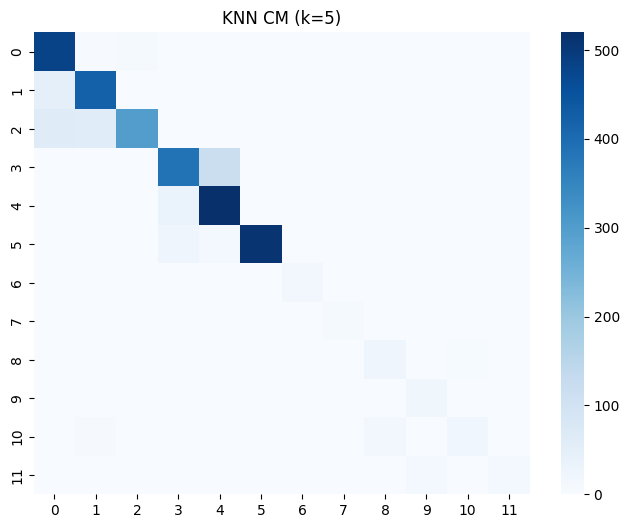

saved knn_quick and scaler


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'models/standard_scaler.joblib')

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
if y_test is not None:
    print('Accuracy', accuracy_score(y_test, y_pred))
    print('Macro F1', f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred, zero_division=0))
    plt.figure(figsize=(8,6)); sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues'); plt.title('KNN CM (k=5)'); plt.show()
else:
    print('Test unlabeled: predictions generated but not evaluated')
joblib.dump(knn, 'models/knn_quick.joblib')
print('saved knn_quick and scaler')

## 4) Grid search template for KNN (fit on training only)
Use StratifiedKFold on training data to choose k and weights. Do not use test set for parameter selection.

In [8]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform','distance'],
    'knn__metric': ['minkowski','euclidean']
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe_knn, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1)

# Uncomment to run grid search on training data:
gs.fit(X_train, y_train)
print('best knn', gs.best_params_, gs.best_score_)
best_knn = gs.best_estimator_
joblib.dump(best_knn, 'models/knn_best.joblib')
print('saved best knn')

# print('Grid search template ready — uncomment fit lines to run tuning on training data.')

Fitting 4 folds for each of 16 candidates, totalling 64 fits


best knn {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__weights': 'distance'} 0.8521323361536559
saved best knn


## 5) Feature selection experiments (fit selectors on training only, then transform test)
We test SelectKBest and PCA to see k-NN sensitivity to dimensionality. Always fit selectors and scalers on training only.

K=20 => macro-F1=0.6523994005629331
K=50 => macro-F1=0.6990078004860938
K=100 => macro-F1=0.705164210085377
K=200 => macro-F1=0.7816194567753015
K=400 => macro-F1=0.7709801865171467
K=561 => macro-F1=0.7871163165698084


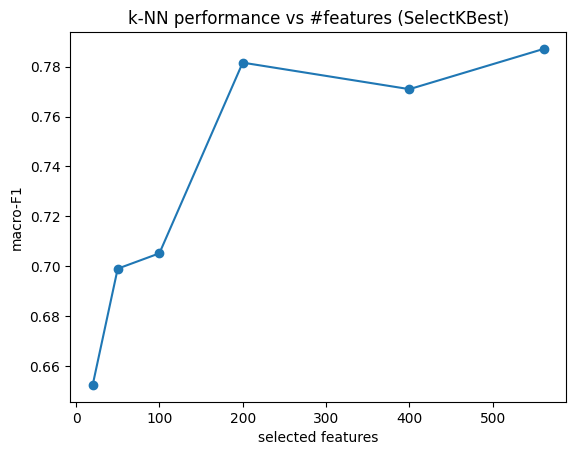

In [9]:
ks = [20,50,100,200,400,800]
results = []
for k in ks:
    k_sel = min(k, X_train.shape[1])
    sel = SelectKBest(f_classif, k=k_sel)
    Xtr_sel = sel.fit_transform(X_train, y_train)
    Xte_sel = sel.transform(X_test)
    scaler_sel = StandardScaler()
    Xtr_scaled = scaler_sel.fit_transform(Xtr_sel)
    Xte_scaled = scaler_sel.transform(Xte_sel)
    knn_tmp = KNeighborsClassifier(n_neighbors=5)
    knn_tmp.fit(Xtr_scaled, y_train)
    ypred = knn_tmp.predict(Xte_scaled)
    score = f1_score(y_test, ypred, average='macro') if y_test is not None else None
    print(f'K={k_sel} => macro-F1={score}')
    results.append((k_sel, score))
    # save selector+scaler for best K manually if desired

res_df = pd.DataFrame(results, columns=['k_features','macro_f1'])
plt.plot(res_df['k_features'], res_df['macro_f1'], '-o'); plt.xlabel('selected features'); plt.ylabel('macro-F1'); plt.title('k-NN performance vs #features (SelectKBest)'); plt.show()

## 6) PCA experiment (fit PCA on scaled training only)
Alternative to feature selection; fit PCA on scaler(X_train) then transform test with same scaler+PCA.

PCs=10 => macro-F1=0.6545170078547592
PCs=20 => macro-F1=0.7413678359405177
PCs=50 => macro-F1=0.753557755557208
PCs=100 => macro-F1=0.7827697811275184
PCs=200 => macro-F1=0.7892520939855933


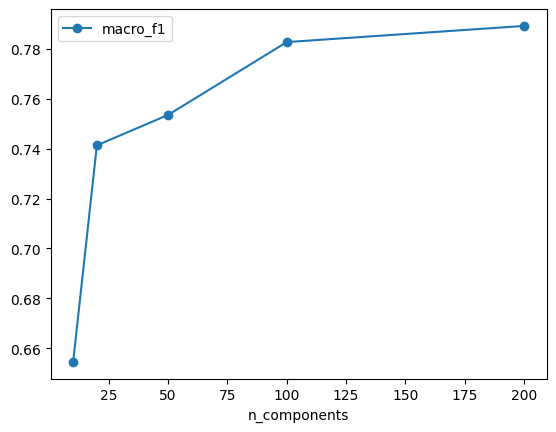

In [10]:
components = [10,20,50,100,200]
explained = []
for c in components:
    n_c = min(c, X_train.shape[1])
    scaler_p = StandardScaler()
    Xtr_scaled = scaler_p.fit_transform(X_train)
    pca = PCA(n_components=n_c, random_state=RANDOM_STATE)
    Xtr_p = pca.fit_transform(Xtr_scaled)
    Xte_p = pca.transform(scaler_p.transform(X_test))
    knn_tmp = KNeighborsClassifier(n_neighbors=5)
    knn_tmp.fit(Xtr_p, y_train)
    ypred = knn_tmp.predict(Xte_p)
    score = f1_score(y_test, ypred, average='macro') if y_test is not None else None
    print(f'PCs={n_c} => macro-F1={score}')
    explained.append((n_c, score))
pd.DataFrame(explained, columns=['n_components','macro_f1']).plot(x='n_components', y='macro_f1', marker='o'); plt.show()

## 7) Save best artifacts (selector/scaler/knn) example
If you found a good selector/scaler combination, save them for reproducibility and inference.

In [11]:
# Example: save scaler and a simple knn pipeline if you want (change names as needed)
joblib.dump(scaler, 'models/standard_scaler.joblib')
joblib.dump(knn, 'models/knn_quick.joblib')
print('saved scaler and knn_quick')

saved scaler and knn_quick


## Notes
- Always fit selectors/scalers on training data only and transform test with them.
- For fair comparisons against RF/XGB/CatBoost use the same selected features and ordering.
- If test is unlabeled, you can still save predictions but must not use test for tuning.